# PRACTICA EVALUACIÓN FINAL - PARTE II #
Esta segunda parte supone el 25% restante de tarea práctica final del módulo de minería de datos. Junto con la parte 1, ambas puntúan el 60% de la nota final.

En esta parte 2 se pretende evaluar los conceptos relacionados con el analisis de series temporales y su aplicación a modelos de predicción.

Comenzando con esta parte de la práctica, en el primer bloque de código, conviene cargar las librerías que se van a utilizar a lo largo del notebook.

In [272]:
# importar librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import boxcox
from statsmodels.tsa.ar_model import AutoReg
import itertools
from statsmodels.tsa.arima.model import ARIMA

En el siguiente paso procedemos a cargar el fichero *Microsoft_Stock.csv* que servirá como conjunto de datos para llevar a cabo toda la evaluación de esta parte II. Se trata de un fichero en el que cada registro contiene para un día concreto datos de apertura, cierre, máximo, mínimo y volumen de cotización de las acciones de Microsoft en la bolsa de Nueva York. Se trata por tanto de un clásico problema de predicción de valores futuros. 

In [4]:
# Cargar el fichero de datos en un DataFrame
stock = pd.read_csv('Microsoft_Stock.csv')

En los siguientes bloques de código el alumno debe programar las sentencias de código que considere oportunas para hacerse una idea general de los datos y de las variables. Visualización de datos, gráficos, etc. Los bloques son orientativos, el alumno puede añadir cuantos considere y codificarlos según su criterio.

In [6]:
# Mostrar los 10 primeros registros
stock.head(10)

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
5,4/9/2015 16:00:00,41.25,41.62,41.25,41.48,25723861
6,4/10/2015 16:00:00,41.63,41.95,41.41,41.72,28022002
7,4/13/2015 16:00:00,41.40,42.06,41.39,41.76,30276692
8,4/14/2015 16:00:00,41.80,42.03,41.39,41.65,24244382
9,4/15/2015 16:00:00,41.76,42.46,41.68,42.26,27343581


In [7]:
# Describir el DataFrame
stock.describe()

,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


In [8]:
# Mostrar las columnas y tipos de datos
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


In [9]:
# ...
stock.nunique()

Date      1511
Open      1409
High      1400
Low       1397
Close     1398
Volume    1511
dtype: int64

Variables númericas:  ['Open' 'High' 'Low' 'Close' 'Volume']


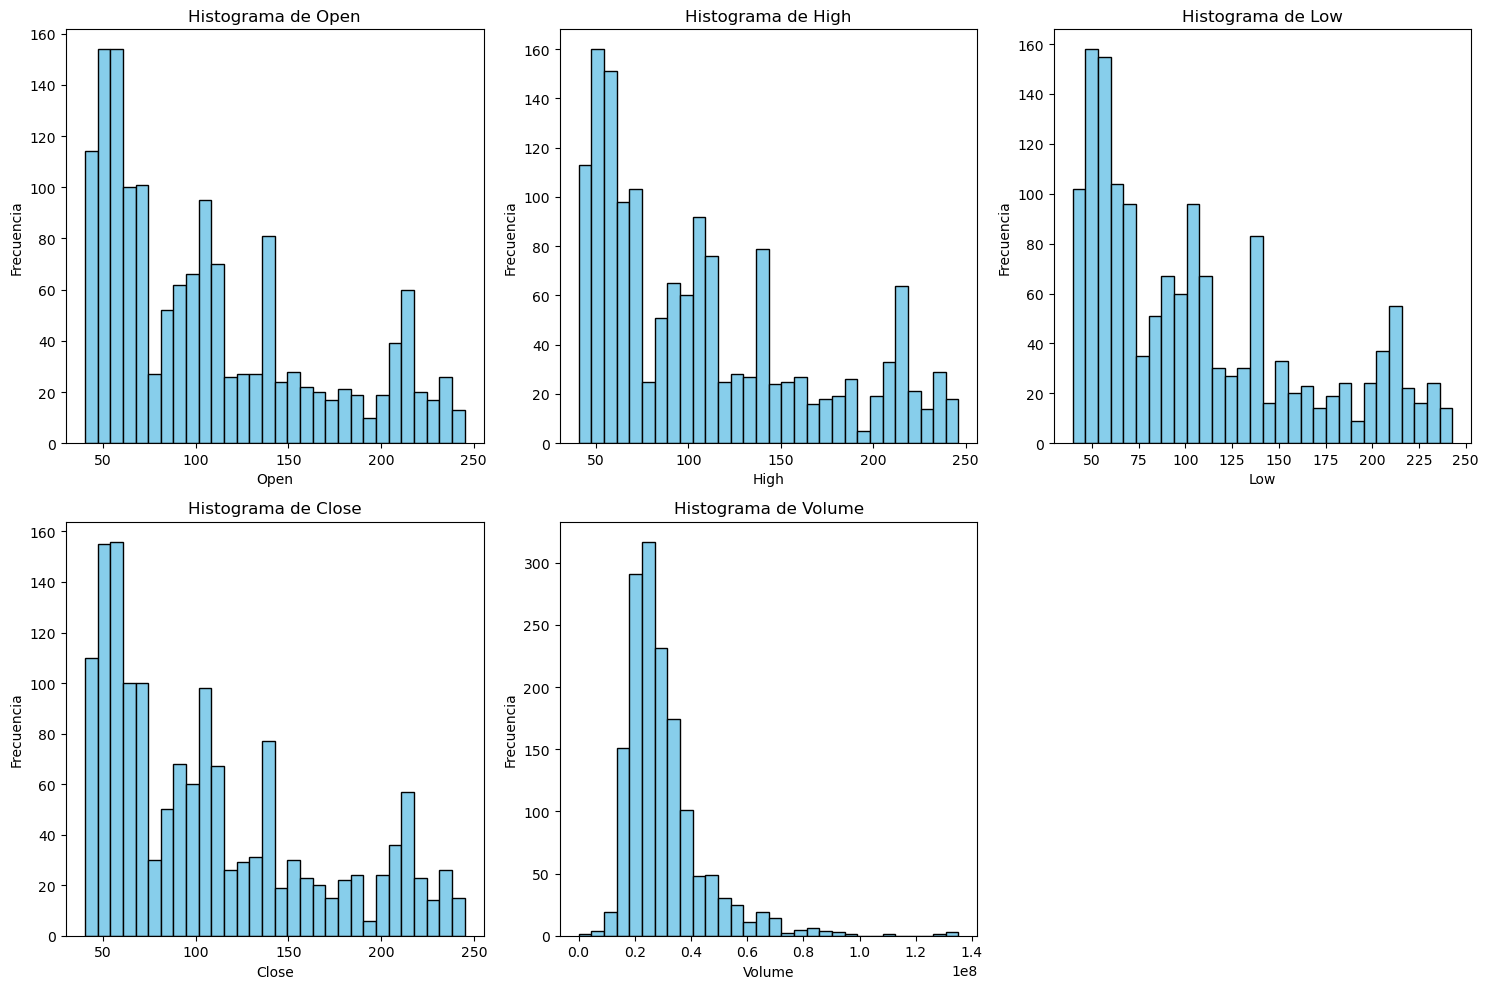

In [10]:
# ...
numericas = stock.select_dtypes(include = [np.number]).columns
print('Variables númericas: ', numericas.values)

num_vars = len(numericas)
fig, axes = plt.subplots(nrows=(num_vars // 3) + 1, ncols=3, figsize=(15, 5 * ((num_vars // 3) + 1)))
axes = axes.flatten()

for i, col in enumerate(numericas):
    axes[i].hist(stock[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histograma de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Se ha de filtrar la serie quedandose solo con los datos desde el año 2020 (incluido) en adelante. Una vez filtrada, mostrar la serie temporal de la variable ***Close*** en un gráfico de línea.

In [12]:
# Filtrar datos desde 2020
stock['Date'] = pd.to_datetime(stock['Date'])

In [13]:
stock_filtrado = stock[stock['Date'].dt.year >= 2020]

In [14]:
stock_filtrado.head(-10)

,Date,Open,High,Low,Close,Volume
1197,2020-01-02 16:00:00,158.78,160.73,158.33,160.62,22634546
1198,2020-01-03 16:00:00,158.32,159.95,158.06,158.62,21121681
1199,2020-01-06 16:00:00,157.08,159.10,156.51,159.03,20826702
1200,2020-01-07 16:00:00,159.32,159.67,157.32,157.58,21881740
1201,2020-01-08 16:00:00,158.93,160.80,157.95,160.09,27762026
...,...,...,...,...,...,...
1496,2021-03-11 16:00:00,234.96,239.17,234.31,237.13,29907586
1497,2021-03-12 16:00:00,234.01,235.82,233.23,235.75,22653662
1498,2021-03-15 16:00:00,234.96,235.19,231.81,234.81,26042669
1499,2021-03-16 16:00:00,236.28,240.06,235.94,237.71,28092196


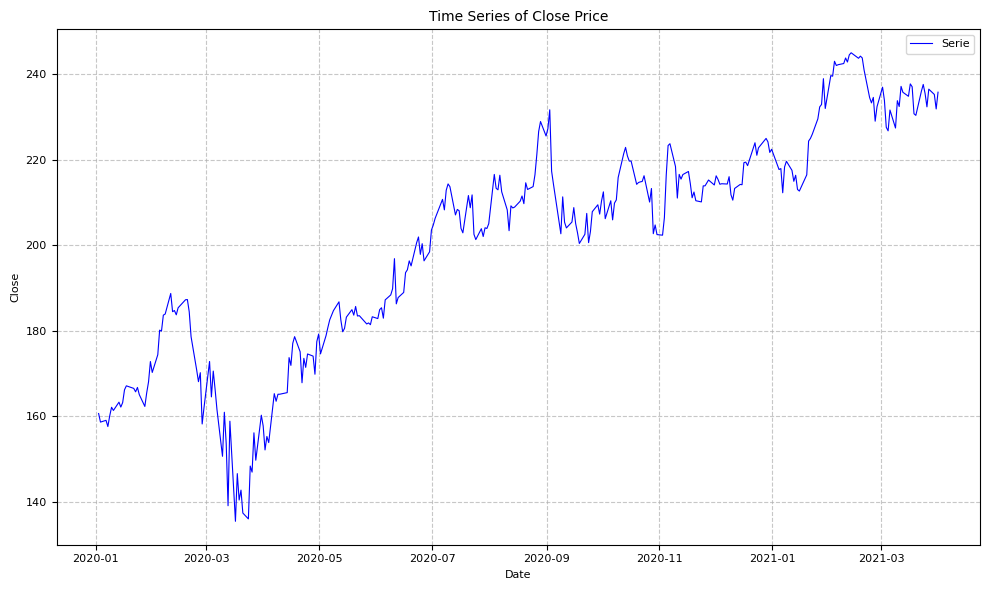

In [15]:
plt.figure(figsize=(10, 6))

# Opciones del gráfico
plt.plot(stock_filtrado['Date'], stock_filtrado['Close'], label="Serie", color='blue', linewidth=0.8)
plt.title("Time Series of Close Price", fontsize=10)
plt.xlabel("Date", fontsize=8)
plt.ylabel("Close", fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7) 
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

C:\Users\swart\AppData\Local\Temp\ipykernel_3824\857214692.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_filtrado["trend_estimated"] = stock_filtrado["Close"].rolling(window=window_long, center=True).mean()


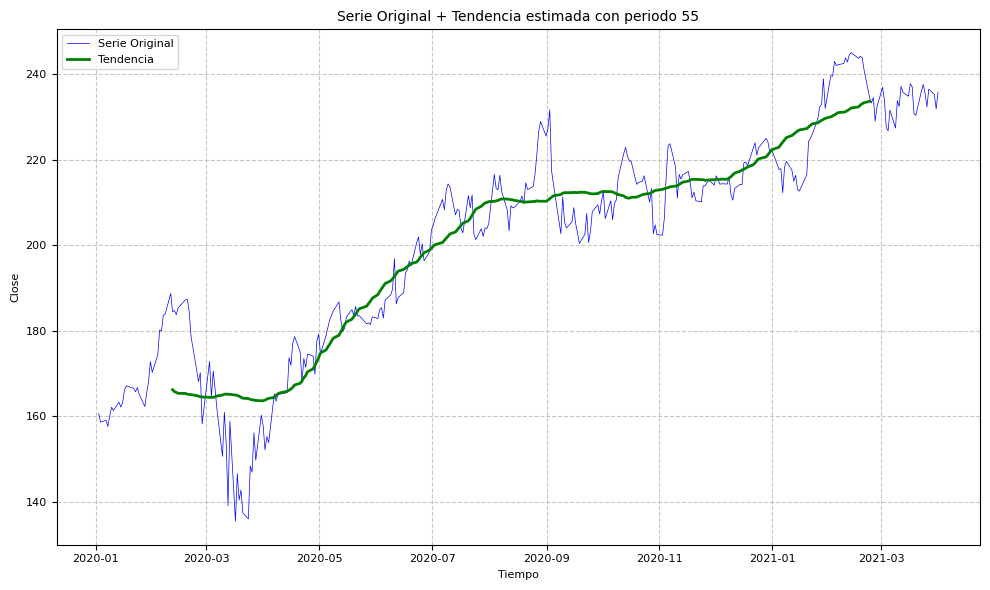

In [16]:
window_long = 55 # Longitud del período (por ejemplo, meses en un año)

# Suavizado para estimar la tendencia (media móvil de window_long puntos)
stock_filtrado["trend_estimated"] = stock_filtrado["Close"].rolling(window=window_long, center=True).mean()

# Mostrar grafica de tendencia
plt.figure(figsize=(10, 6))

# Serie Temporal más tendencia estimada
plt.plot(stock_filtrado['Date'], stock_filtrado['Close'], label="Serie Original", color='blue', linewidth=0.5)
plt.plot(stock_filtrado['Date'], stock_filtrado['trend_estimated'], label="Tendencia", color='green', linewidth=2)
plt.title("Serie Original + Tendencia estimada con periodo 55", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Close", fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7) 
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

C:\Users\swart\AppData\Local\Temp\ipykernel_3824\1781530448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_filtrado["trend_estimated"] = stock_filtrado["Close"].rolling(window=window_long, center=True).mean()


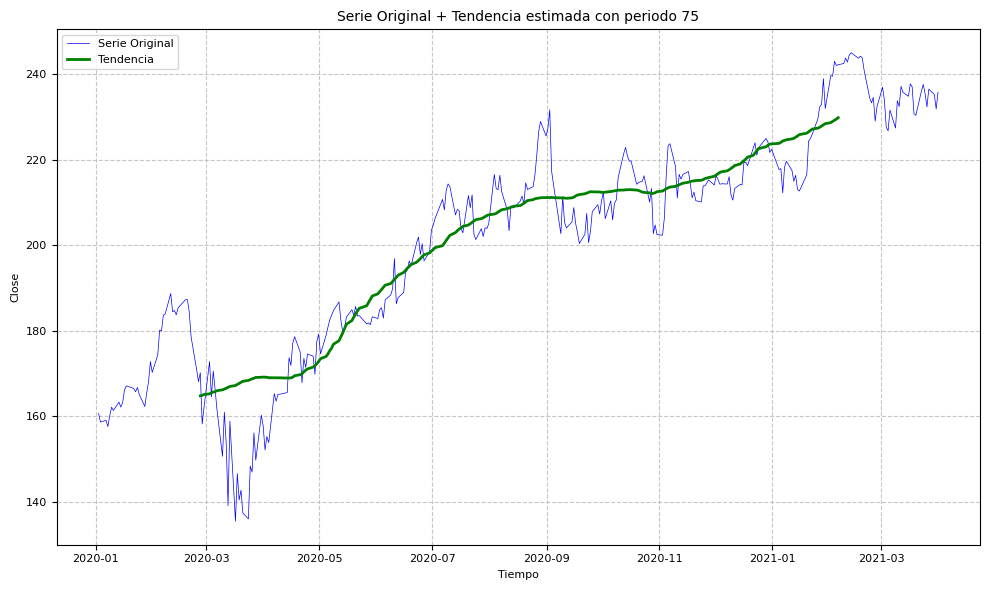

In [17]:
window_long = 75 # Longitud del período (por ejemplo, meses en un año)

# Suavizado para estimar la tendencia (media móvil de window_long puntos)
stock_filtrado["trend_estimated"] = stock_filtrado["Close"].rolling(window=window_long, center=True).mean()

# Mostrar grafica de tendencia
plt.figure(figsize=(10, 6))

# Serie Temporal más tendencia estimada
plt.plot(stock_filtrado['Date'], stock_filtrado['Close'], label="Serie Original", color='blue', linewidth=0.5)
plt.plot(stock_filtrado['Date'], stock_filtrado['trend_estimated'], label="Tendencia", color='green', linewidth=2)
plt.title("Serie Original + Tendencia estimada con periodo 75", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Close", fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7) 
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

C:\Users\swart\AppData\Local\Temp\ipykernel_3824\180524141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_filtrado["trend_estimated"] = stock_filtrado["Close"].rolling(window=window_long, center=True).mean()


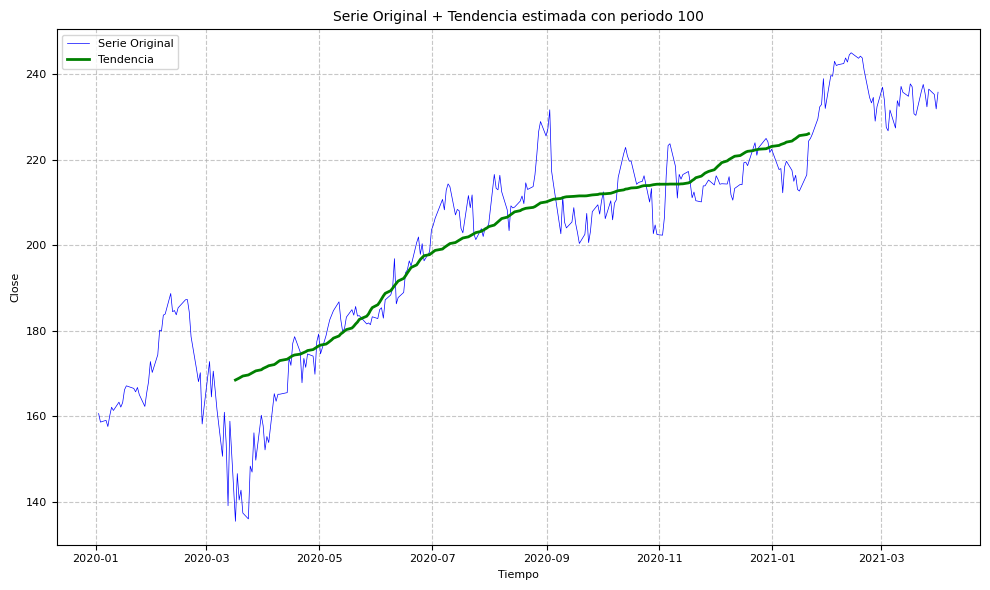

In [18]:
window_long = 100 # Longitud del período (por ejemplo, meses en un año)

# Suavizado para estimar la tendencia (media móvil de window_long puntos)
stock_filtrado["trend_estimated"] = stock_filtrado["Close"].rolling(window=window_long, center=True).mean()

# Mostrar grafica de tendencia
plt.figure(figsize=(10, 6))

# Serie Temporal más tendencia estimada
plt.plot(stock_filtrado['Date'], stock_filtrado['Close'], label="Serie Original", color='blue', linewidth=0.5)
plt.plot(stock_filtrado['Date'], stock_filtrado['trend_estimated'], label="Tendencia", color='green', linewidth=2)
plt.title("Serie Original + Tendencia estimada con periodo 100", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Close", fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7) 
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [19]:
stock_filtrado['seasonality_noise'] = stock_filtrado['Close'] - stock_filtrado['trend_estimated']

C:\Users\swart\AppData\Local\Temp\ipykernel_3824\1277885320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_filtrado['seasonality_noise'] = stock_filtrado['Close'] - stock_filtrado['trend_estimated']


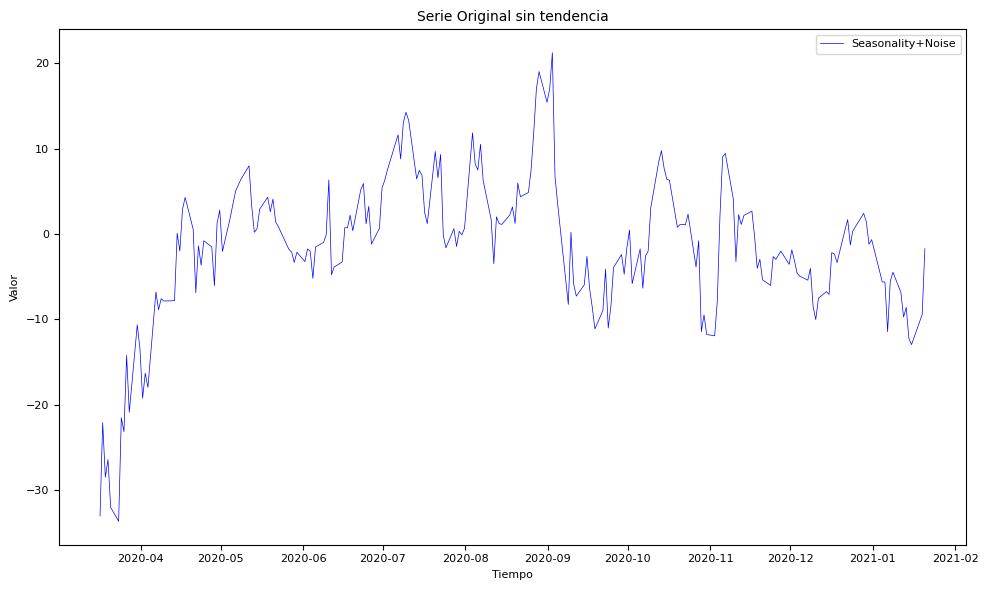

In [20]:
# Mostrar grafica de tendencia
plt.figure(figsize=(10, 6))

# Serie Temporal más tendencia estimada
plt.plot(stock_filtrado['Date'], stock_filtrado['seasonality_noise'], label="Seasonality+Noise", color='blue', linewidth=0.5)
plt.title("Serie Original sin tendencia", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valor", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [21]:
window_long = 100  # Longitud del período

# Aislar estacionalidad promediando por periodo (ciclo estacional)
date_offset = (stock_filtrado["Date"] - stock_filtrado["Date"].min()).dt.days

stock_filtrado["period"] = date_offset % window_long
seasonality_avg = stock_filtrado.groupby("period")["seasonality_noise"].mean()
stock_filtrado["seasonality_estimated"] = stock_filtrado["period"].map(seasonality_avg)

C:\Users\swart\AppData\Local\Temp\ipykernel_3824\1196079261.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_filtrado["period"] = date_offset % window_long
C:\Users\swart\AppData\Local\Temp\ipykernel_3824\1196079261.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_filtrado["seasonality_estimated"] = stock_filtrado["period"].map(seasonality_avg)


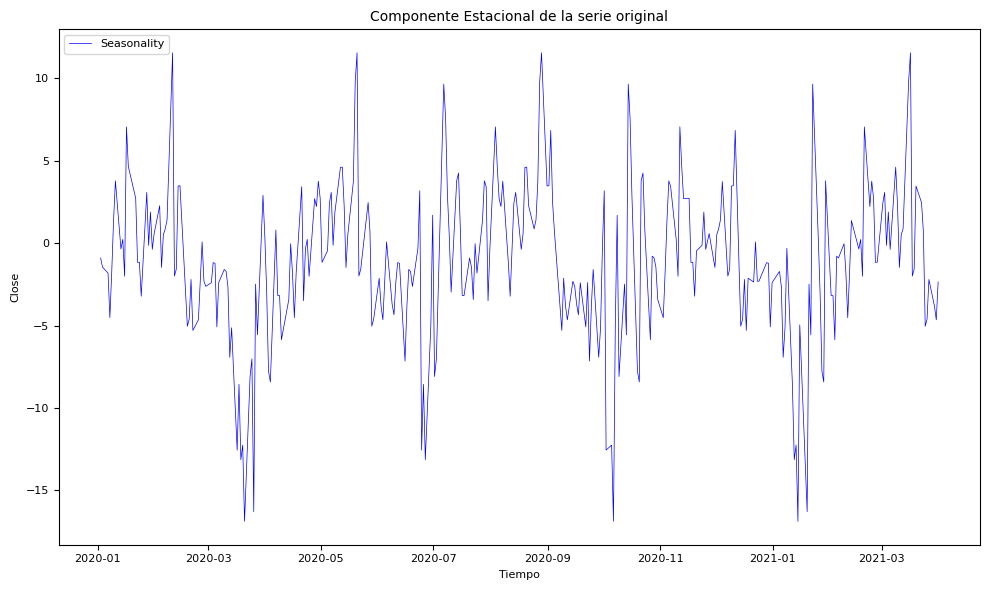

In [22]:
# Mostrar grafica de tendencia
plt.figure(figsize=(10, 6))

# Serie Temporal más tendencia estimada
plt.plot(stock_filtrado["Date"], stock_filtrado['seasonality_estimated'], label="Seasonality", color='blue', linewidth=0.5)
plt.title("Componente Estacional de la serie original", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Close", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [23]:
stock_filtrado["noise_estimated_add"] = stock_filtrado["seasonality_noise"] - stock_filtrado['seasonality_estimated']

C:\Users\swart\AppData\Local\Temp\ipykernel_3824\289206080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_filtrado["noise_estimated_add"] = stock_filtrado["seasonality_noise"] - stock_filtrado['seasonality_estimated']


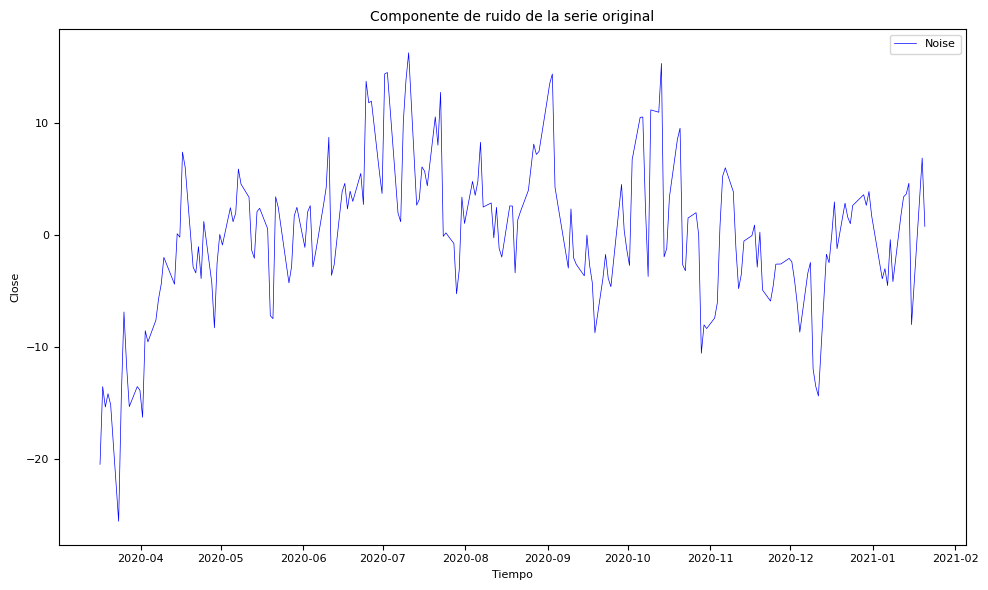

In [24]:
plt.figure(figsize=(10, 6))

# Serie Temporal más tendencia estimada
plt.plot(stock_filtrado['Date'], stock_filtrado['noise_estimated_add'], label="Noise", color='blue', linewidth=0.5)
plt.title("Componente de ruido de la serie original", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Close", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

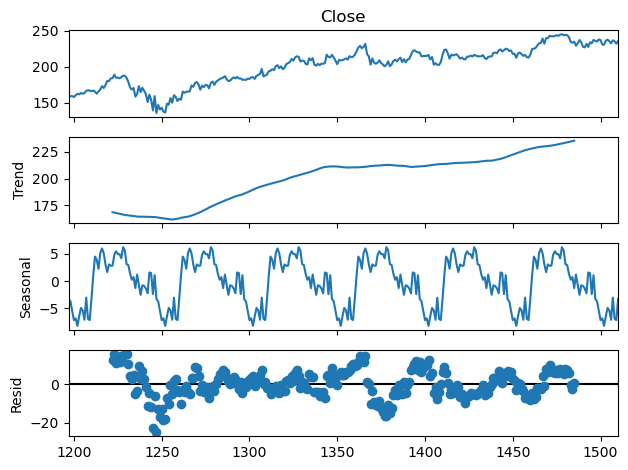

In [25]:
stock_decomposed = seasonal_decompose(stock_filtrado['Close'], model='additive', period=50)  # Ajusta el período según corresponda (diario, anual, etc.)

# Graficamos la descomposición
stock_decomposed.plot()
plt.show()

# Acceder a la tendencia
tendencia = stock_decomposed.trend.dropna()

In [26]:
stock_filtrado['seasonality_noise'] = (stock_filtrado['Close']+1) - stock_filtrado['trend_estimated']

C:\Users\swart\AppData\Local\Temp\ipykernel_3824\3716046842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_filtrado['seasonality_noise'] = (stock_filtrado['Close']+1) - stock_filtrado['trend_estimated']


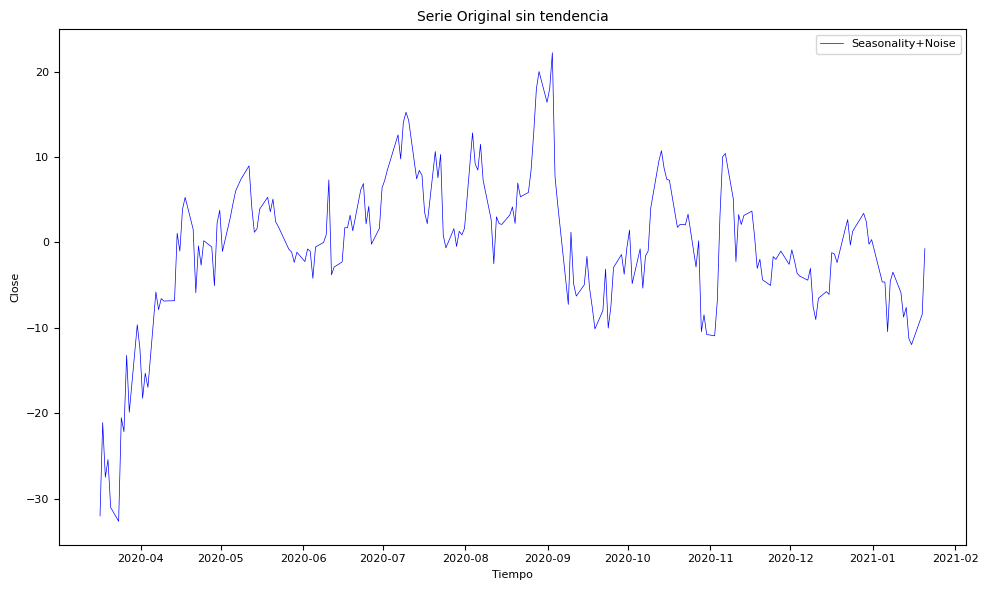

In [27]:
# Mostrar grafica de tendencia
plt.figure(figsize=(10, 6))

# Serie Temporal más tendencia estimada
plt.plot(stock_filtrado['Date'], stock_filtrado['seasonality_noise'], label="Seasonality+Noise", color='blue', linewidth=0.5)
plt.title("Serie Original sin tendencia", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Close", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [28]:
window_long = 100  # Longitud del período

# Aislar estacionalidad promediando por periodo (ciclo estacional)
date_offset = (stock_filtrado["Date"] - stock_filtrado["Date"].min()).dt.days

stock_filtrado["period"] = date_offset % window_long
seasonality_avg = stock_filtrado.groupby("period")["seasonality_noise"].mean()
stock_filtrado["seasonality_estimated"] = stock_filtrado["period"].map(seasonality_avg)

C:\Users\swart\AppData\Local\Temp\ipykernel_3824\1196079261.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_filtrado["period"] = date_offset % window_long
C:\Users\swart\AppData\Local\Temp\ipykernel_3824\1196079261.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_filtrado["seasonality_estimated"] = stock_filtrado["period"].map(seasonality_avg)


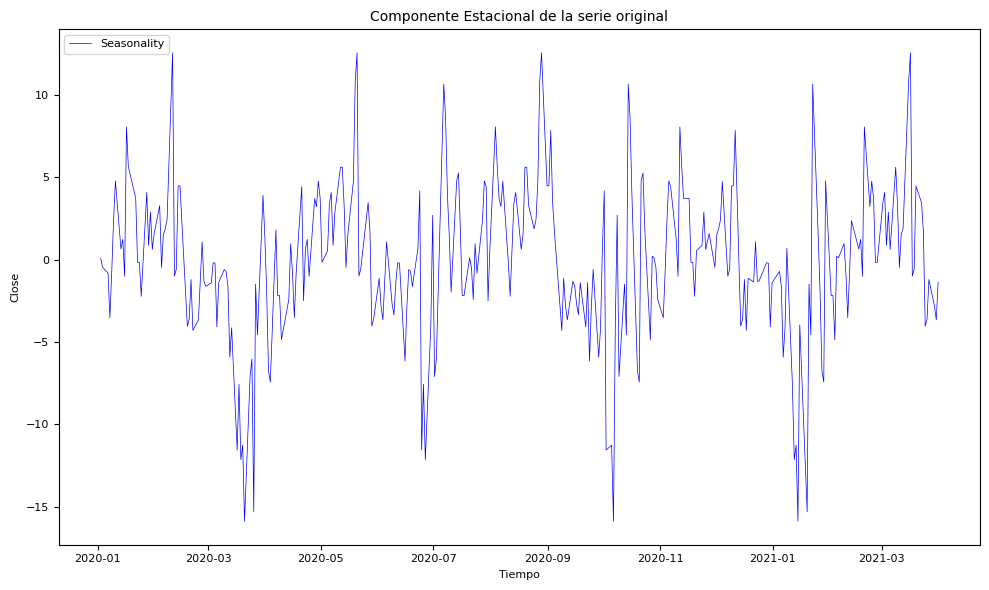

In [29]:
plt.figure(figsize=(10, 6))

# Serie Temporal más tendencia estimada
plt.plot(stock_filtrado['Date'], stock_filtrado['seasonality_estimated'], label="Seasonality", color='blue', linewidth=0.5)
plt.title("Componente Estacional de la serie original", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Close", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [30]:
stock_filtrado["noise_estimated_mult"] = stock_filtrado["seasonality_noise"] / stock_filtrado["seasonality_estimated"]

C:\Users\swart\AppData\Local\Temp\ipykernel_3824\3708135394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_filtrado["noise_estimated_mult"] = stock_filtrado["seasonality_noise"] / stock_filtrado["seasonality_estimated"]


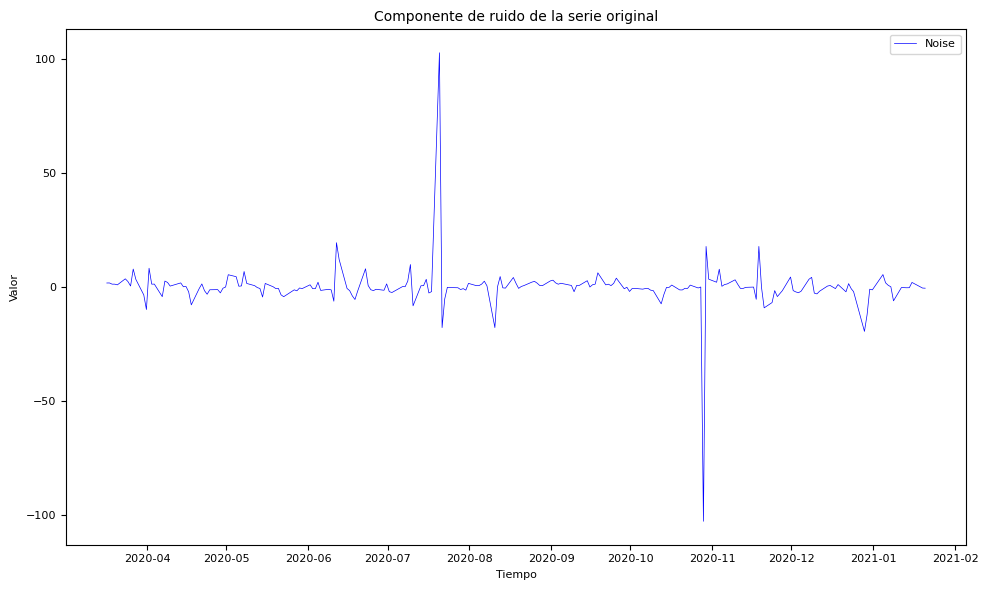

In [31]:
plt.figure(figsize=(10, 6))

# Serie Temporal más tendencia estimada
plt.plot(stock_filtrado['Date'].iloc[50:], stock_filtrado['noise_estimated_mult'].iloc[50:]-1, label="Noise", color='blue', linewidth=0.5)
plt.title("Componente de ruido de la serie original", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valor", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

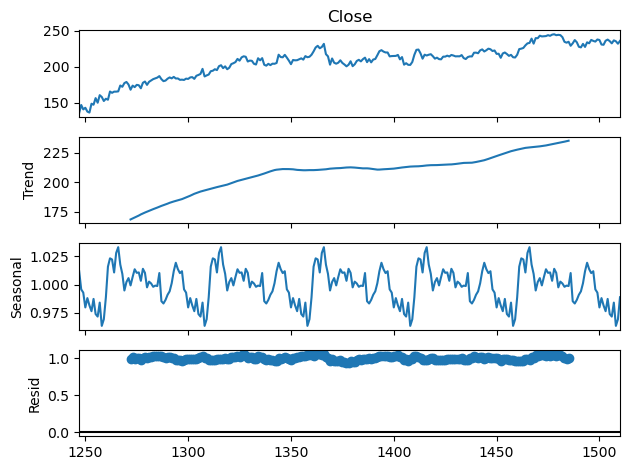

In [32]:
df_decomposed = seasonal_decompose(stock_filtrado['Close'].iloc[50:], model='multiplicative', period=50)  # Ajusta el período según corresponda (diario, anual, etc.)

# Graficamos la descomposición
df_decomposed.plot()
plt.show()

# Acceder a la tendencia
tendencia = df_decomposed.trend.dropna()

### Pregunta 1 ###
En primera instancia echando un vistazo a la serie en la gráfica, ¿Qué pinta tiene la serie en cuanto a estacionariedad? Describe brevemente las impresiones acerca de porque parece que la serie es o no estacionaria.

***Respuesta:***

La serie esta creciendo con el tiempo osea tiene tendencia de crecimiento. Aunque es leve se puede observar un tipo de ondas que se repiten en el tiempo. Por lo que se decidio hacer la descomposicion y los datos tienen estacionalidad. Podemos comprobar que no tiene estacionariedad porque se le pudo eliminar la tendencia

A continuación pasamos a analizar desde un punto de vista más formal la estacionariedad de la serie. En primer lugar calcular las funciones de autocorrelación y autocorrelación parcial y mostrar las gráficas con ambas funciones.

In [37]:
stock_corr = stock_filtrado.copy()

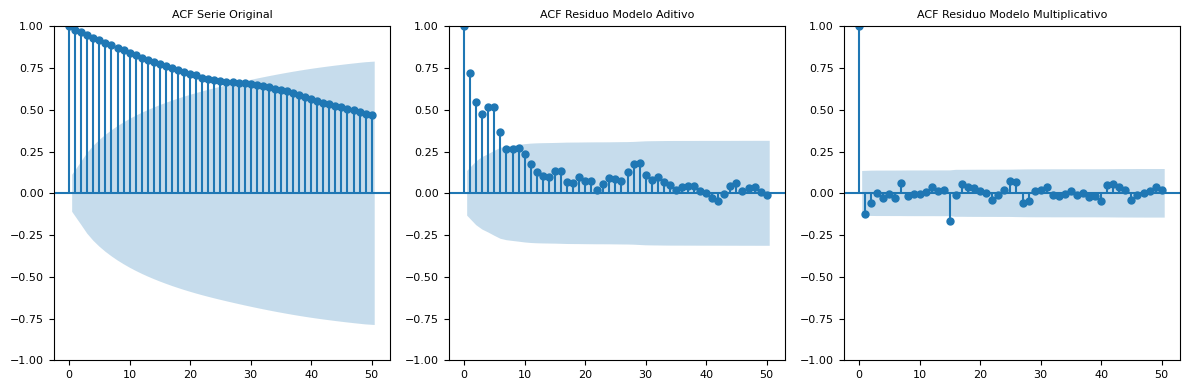

In [38]:
# Gráfica ACF
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plot_acf(stock_corr['Close'].dropna(), lags=50, ax=plt.gca())  # Ajustar el número de lags
plt.title('ACF Serie Original', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Graficar ACF Residuo Aditivo
plt.subplot(1, 3, 2)
plot_acf(stock_corr['noise_estimated_add'].dropna(), lags=50, ax=plt.gca())  # Ajustar el número de lags
plt.title('ACF Residuo Modelo Aditivo', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Graficar ACF Residuo Multiplicativo
plt.subplot(1, 3, 3)
plot_acf(stock_corr['noise_estimated_mult'].dropna(), lags=50, ax=plt.gca())  # Ajustar el número de lags
plt.title('ACF Residuo Modelo Multiplicativo', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig('ACF.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

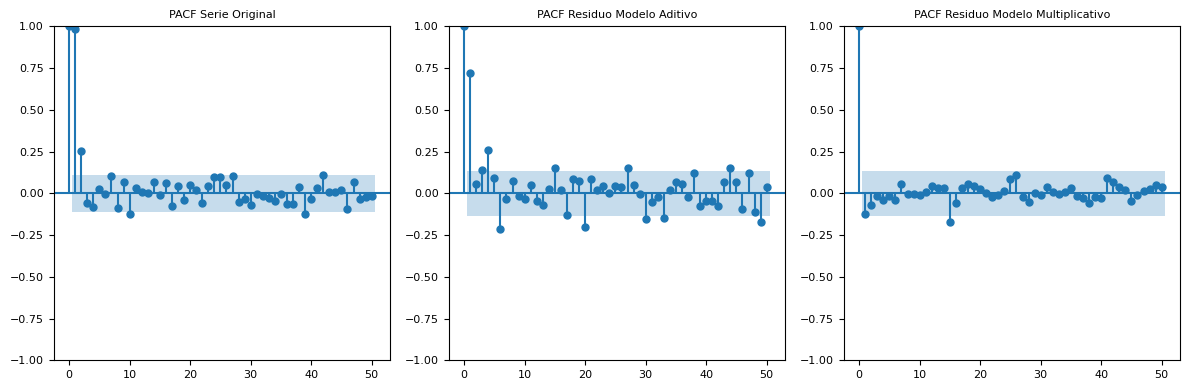

In [39]:
# Gráfica PACF
plt.figure(figsize=(12, 4))

# PACF for Original Series
plt.subplot(1, 3, 1)
plot_pacf(stock_corr['Close'].dropna(), lags=50, method='yw', ax=plt.gca())  # Yule-Walker method
plt.title('PACF Serie Original', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# PACF for Additive Model Residuals
plt.subplot(1, 3, 2)
plot_pacf(stock_corr['noise_estimated_add'].dropna(), lags=50, method='yw', ax=plt.gca())
plt.title('PACF Residuo Modelo Aditivo', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# PACF for Multiplicative Model Residuals
plt.subplot(1, 3, 3)
plot_pacf(stock_corr['noise_estimated_mult'].dropna(), lags=50, method='yw', ax=plt.gca())
plt.title('PACF Residuo Modelo Multiplicativo', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig('PACF.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

### Pregunta 2 ###
A la vista de las 2 gráficas de autocorrelación, ¿Se aprecian signos de estacionariedad en la serie? ¿Por qué? ¿Se aprecian signos de estacionalidad? ¿Por qué?

***Respuesta:***

La serie no presenta estacionariedad ya que podemos ver como ACF disminuye lentamente y PACF tiene rezagos significativos. En cambio los residuos se vuelven estacionarios debido a que se elimino la tendencia.

En cambio la estacionalidad es más dificil de predecir ya que no se ven picos fuertes en la serie original y en ACF, pero el modelo aditivo muestra un tipo de repeticiones

Ahora mediante un test de Dickey Fuller aumentado, realizamos la última comprobación de estacionariedad de la serie.

In [44]:
# Test de Dickey Fuller Aumentado
adf_test = adfuller(stock_corr['Close'])  # Eliminar valores NaN generados por diff
print(f'Estadístico ADF: {adf_test[0]}')
print(f'P-valor: {adf_test[1]}')
if adf_test[1] < 0.05:
    print("La serie es ahora estacionaria")
else:
    print("La serie aún no es estacionaria")

Estadístico ADF: -1.4029588977517928
P-valor: 0.5808567665335335
La serie aún no es estacionaria


In [45]:
adf_test = adfuller(stock_corr['noise_estimated_add'].dropna())  # Eliminar valores NaN generados por diff
print(f'Estadístico ADF: {adf_test[0]}')
print(f'P-valor: {adf_test[1]}')
if adf_test[1] < 0.05:
    print("La serie es ahora estacionaria")
else:
    print("La serie aún no es estacionaria")

Estadístico ADF: -4.306189311607791
P-valor: 0.0004333764434506301
La serie es ahora estacionaria


In [46]:
adf_test = adfuller(stock_corr['noise_estimated_mult'].dropna())  # Eliminar valores NaN generados por diff
print(f'Estadístico ADF: {adf_test[0]}')
print(f'P-valor: {adf_test[1]}')
if adf_test[1] < 0.05:
    print("La serie es ahora estacionaria")
else:
    print("La serie aún no es estacionaria")

Estadístico ADF: -16.497101250140187
P-valor: 2.1656067974737086e-29
La serie es ahora estacionaria


### Pregunta 3 ###
Según el test realizado, ¿es estacionaria la serie?

***Respuesta:***

Segun el test Dickey Fuller Aumentado es casi una serie estacionaria.

Seguimos con el analisis y para ello vamos a tratar de modelar la serie con un suavizado exponencial y predecir con este modelo algunos de los puntos finales de la serie. En primer lugar, el alumno debe escoger, teniendo en cuenta lo aprendido en el analisis realizado hasta aquí, el modelo adecuado de suavizado exponencial. A continuación, utilizará todos los datos excepto los 30 últimos días de la serie, y modelará el suavizado con dichos datos. Con este modelo, debe predecir los 30 valores restantes y por último, debe mostrar en una misma gráfica: la serie original en un color hasta el punto donde comienzan los datos de validación (30 últimos puntos), los 30 últimos puntos de la serie original en otro color y, por último, en un tercer color, los puntos predichos por el modelo de suavizado.

In [51]:
stock_suave = stock_corr.copy()

In [52]:
# Separar en conjunto de entrenamiento y validación 
train = stock_suave['Close'][:-30]
test = stock_suave['Close'][-30:]

In [53]:
# Crear y ajustar el modelo de suavizado escogido

seasonal_periods = 5 
model_hw = ExponentialSmoothing(train, trend='add', seasonal='add', 
                              seasonal_periods=seasonal_periods)
fitted_model_hw = model_hw.fit(smoothing_level=0.02, smoothing_trend=0.01)

C:\Users\swart\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [54]:
# Predecir los datos validación
predictions_hw = fitted_model_hw.forecast(steps=30)

C:\Users\swart\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\swart\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


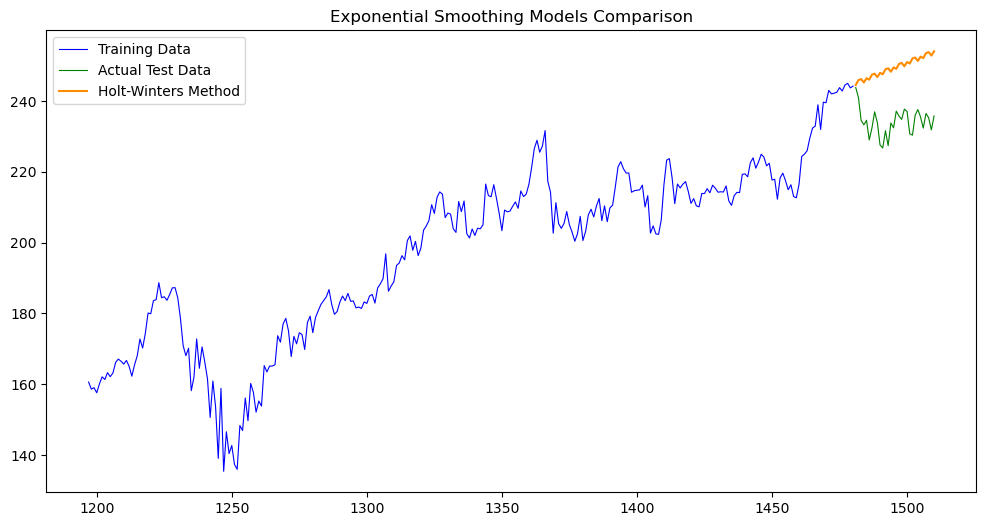

In [55]:
# Mostrar en gráfico los resultados y la serie original.
plt.figure(figsize=(12, 6))

# Original data
plt.plot(train, label='Training Data', color='blue', linewidth=0.8)
plt.plot(test.index, test, label='Actual Test Data', color='green', linewidth=0.8)

plt.plot(test.index, predictions_hw, label='Holt-Winters Method', color='darkorange', linewidth=1.5)

plt.title('Exponential Smoothing Models Comparison')
plt.legend()
plt.show()

In [56]:
# Crear y ajustar el modelo de suavizado escogido
model_holt = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=5)
model_holt  = model_holt.fit(optimized=True)

C:\Users\swart\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [57]:
# Predecir los datos validación
predictions_holt = model_holt.forecast(steps=30)
predictions2 = model_holt.fittedvalues



C:\Users\swart\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\swart\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


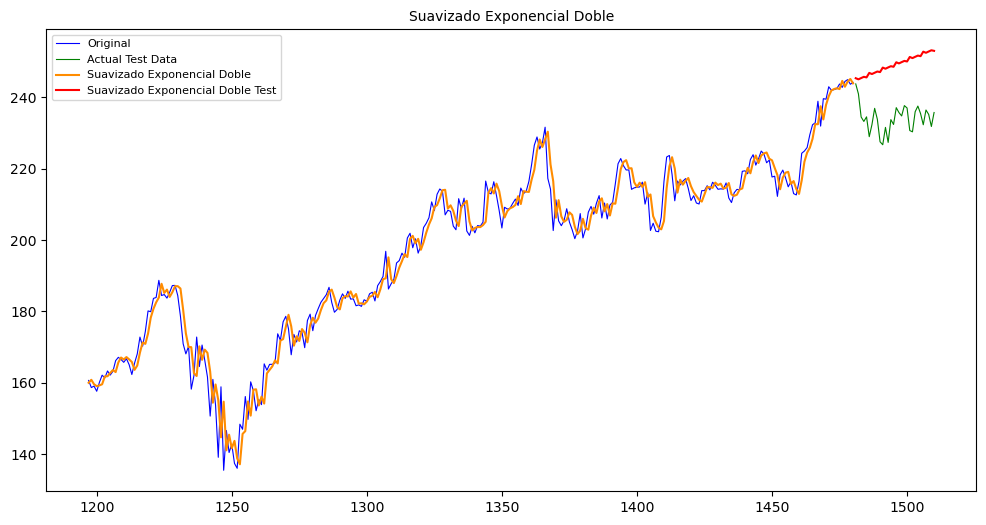

In [58]:
# Mostrar en gráfico los resultados y la serie original.
plt.figure(figsize=(12, 6))
plt.plot(train, label='Original', color='blue', linewidth=0.8)
plt.plot(test.index, test, label='Actual Test Data', color='green', linewidth=0.8)
plt.plot(predictions2, label='Suavizado Exponencial Doble', color='darkorange', linewidth=1.5)
plt.plot(test.index, predictions_holt, label='Suavizado Exponencial Doble Test', color='red', linewidth=1.5)
plt.title('Suavizado Exponencial Doble', fontsize=10)
plt.legend(fontsize=8)
plt.show()

### Pregunta 4 ###
¿Qué tipo de suavizado exponencial se ha empleado y por qué?

***Respuesta:***

Primero se trato de utilizar el Holt-Winters para probar si se tiene estacionalidad. Al graficar se observa como no funciona ese metodo por lo que se decidio utilizar el metodo doble o Holt, ya que no necesita tener estacionalidad, al observar la grafica obtenida podemos ver que esta siguiendo casi cerca la linea original pero al momento de predecir su linea va directamente en contra de la data real

Pasamos ahora a entrenar un modelo autoregresivo para, de nuevo, predecir los 30 últimos valores. En este caso, si en puntos anteriores de esta práctica se hubiera determinado que la serie no es estacionaria, se debe convertir en estacionaria y comprobar que efectivamente lo es después de la transformación. Una vez que sea estacionaria, se ha de seleccionar en base a la función de autocorrelación (ACF) y/o la autocorrelación parcial (PACF) el orden adecuado del modelo autoregresivo (AR).

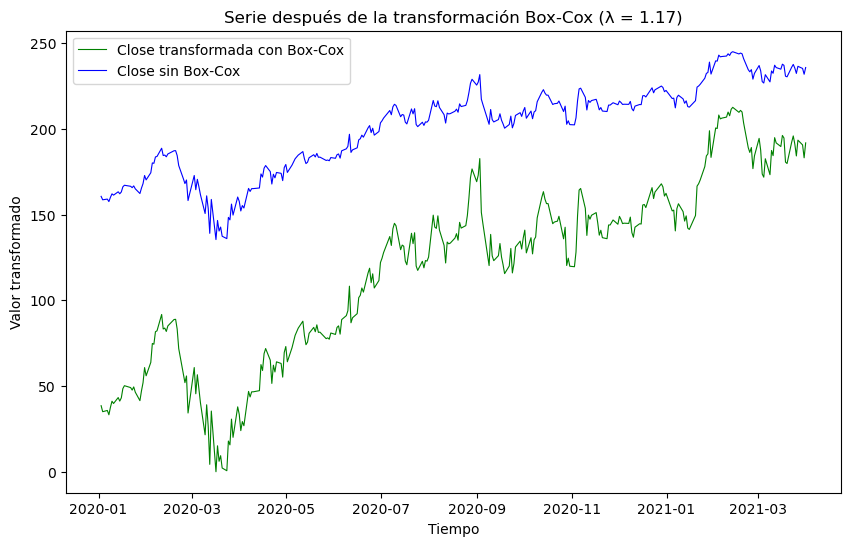

In [63]:
# Transformar la serie en estacionaria en caso de que no lo fuera
stock_estacio = stock_corr.copy()
stock_estacio['close_positiva'] = stock_estacio['Close'] - np.min(stock_estacio['Close']) + 1  # Ajuste para valores positivos
stock_estacio['close_boxcox'], lambda_bc = boxcox(stock_estacio['close_positiva'])  # Transformación Box-Cox

plt.figure(figsize=(10, 6))
plt.plot(stock_estacio['Date'], stock_estacio['close_boxcox'], label="Close transformada con Box-Cox", color="green", linewidth=0.8)
plt.plot(stock_estacio['Date'], stock_estacio['Close'], label="Close sin Box-Cox", color="blue", linewidth=0.8)
plt.title(f"Serie después de la transformación Box-Cox (λ = {lambda_bc:.2f})")
plt.xlabel("Tiempo")
plt.ylabel("Valor transformado")
plt.legend()
plt.show()

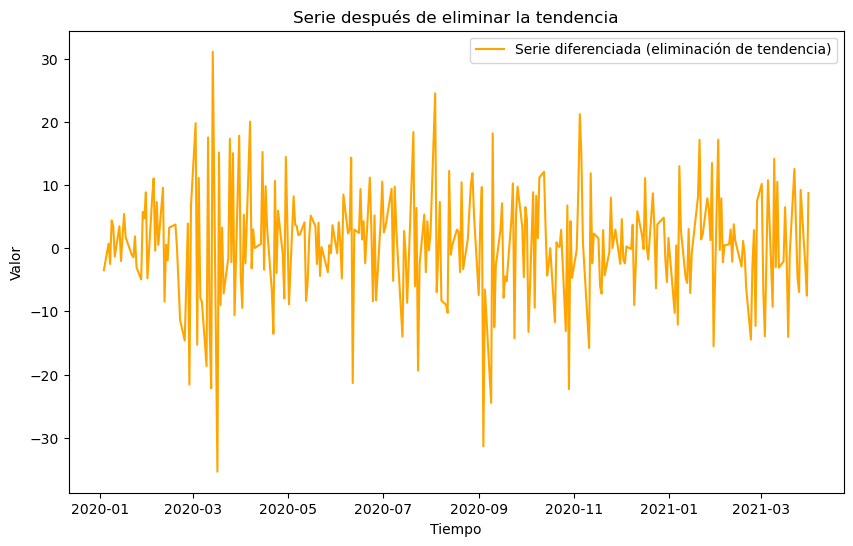

In [64]:
data_diff = np.diff(stock_estacio['close_boxcox'], n=1)
stock_estacio['close_boxcox_diff'] = np.concatenate(([np.nan], data_diff))

plt.figure(figsize=(10, 6))
plt.plot(stock_estacio['Date'], stock_estacio['close_boxcox_diff'], label="Serie diferenciada (eliminación de tendencia)", color="orange")
plt.title("Serie después de eliminar la tendencia")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.show()

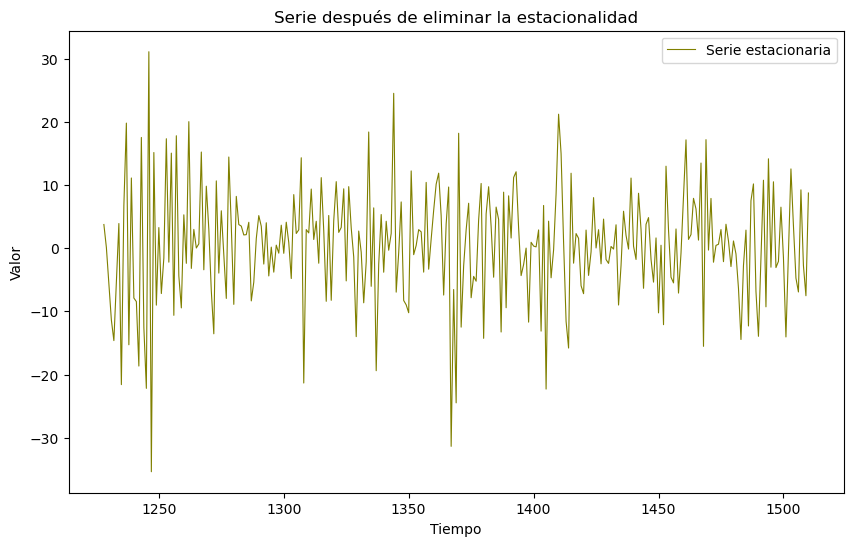

In [182]:
seasonal_lag = 30
serie_diff_seasonal = stock_estacio['close_boxcox_diff'].dropna().iloc[seasonal_lag:]

time_seasonal = serie_diff_seasonal.index

plt.figure(figsize=(10, 6))
plt.plot(time_seasonal, serie_diff_seasonal, label="Serie estacionaria", color="olive", linewidth=0.8)
plt.title("Serie después de eliminar la estacionalidad")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.show()

In [184]:
# Comprobación de estacionariedad
adf_test = adfuller(serie_diff_seasonal)  # Eliminar valores NaN generados por diff
print(f'Estadístico ADF: {adf_test[0]}')
print(f'P-valor: {adf_test[1]:.5f}')
print('Valores críticos:', adf_test[4])
if adf_test[1] < 0.05:
    print("La serie es ahora estacionaria")
else:
    print("La serie aún no es estacionaria")

Estadístico ADF: -21.940400335738808
P-valor: 0.00000
Valores críticos: {'1%': -3.4537536300652, '5%': -2.8718443180148836, '10%': -2.572260641818822}
La serie es ahora estacionaria


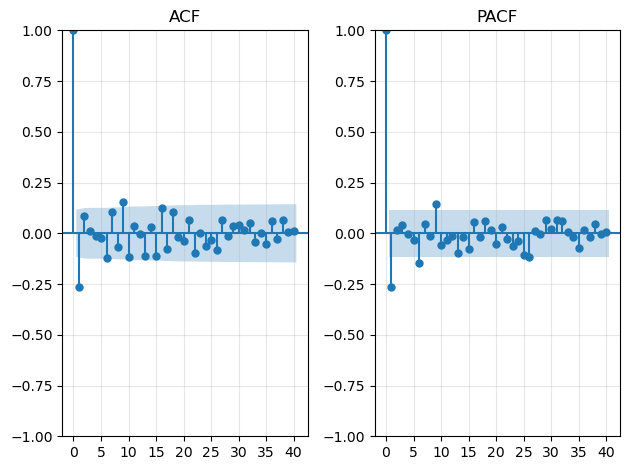

In [186]:
# Mostrar la función de autocorrelación y autocorrelación parcial
# ACF
plt.subplot(1, 2, 1)
plot_acf(serie_diff_seasonal.dropna(), lags=40, ax=plt.gca(), title='ACF')
plt.xticks(range(0, 41, 5))  # Lags cada 5 unidades
plt.grid(alpha=0.3)

# PACF
plt.subplot(1, 2, 2)
plot_pacf(serie_diff_seasonal.dropna(), lags=40, ax=plt.gca(), title='PACF', method='ywm')  # Método recomendado
plt.xticks(range(0, 41, 5))
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Pregunta 5 ###
¿Cual es el orden del modelo autoregresivo que se ha seleccionado y por qué?

***Respuesta:***

Se utilizo el Boxcox y la elimnación de tendencia por diferenciacion, para eliminar la varianza y la tendencia. como tiene un bajo nivel de estacionalidad con esos 2 pasos se puede volver estacionario.

Una vez escogido el orden del modelo autorregresivo, pasamos a entrenar el modelo y a predecir los 30 últimos valores. Por tanto lo primero será, como en ejercicios anteriores, separar por un lado la serie original transformada en estacionaria en caso de que no lo fuera, y eso si, quitandole los últimos 30 puntos. Una vez entrenado, se ha de mostrar el resumen de los parametros del modelo, coeficientes y demás métricas habituales. A continuación, utilizar el modelo para predecir los últimos 30 valores y mostrarlos en un gráfico de lineas junto con la serie original. Antes de pintarlos, en caso de que la serie original haya sido transformada para convertirla en estacionaria, será necesario deshacer las transformaciones de los valores predichos y, ahora si, pintarla junto con los valores de la serie original.

In [229]:
serie = stock[stock['Date'].dt.year >= 2020]

In [231]:
serie_static = serie['Close']

In [233]:
# Crear y ajustar el modelo autorregresivo del orden escogido
serie_boxcox, lambda_bc = boxcox(serie_static)
serie_diff = np.diff(serie_boxcox, n=1)
n_total = len(serie_boxcox)
# En la escala diferenciada hay n_total - 1 puntos
train_diff = serie_diff[:-30]
# Para revertir la diferenciación se necesita el último valor conocido de la serie_boxcox de entrenamiento
last_train_value = serie_boxcox[len(train_diff)]

In [235]:
# Mostrar el resumen de los parametros y resultados del entrenamiento del modelo
orden_ar = 5  # Cambia este valor según tu análisis previo
modelo_ar = AutoReg(train_diff, lags=orden_ar, old_names=False)
modelo_ar_fit = modelo_ar.fit()
print(modelo_ar_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  283
Model:                     AutoReg(5)   Log Likelihood               -2923.411
Method:               Conditional MLE   S.D. of innovations           8927.826
Date:                Thu, 27 Feb 2025   AIC                           5860.822
Time:                        12:49:15   BIC                           5886.215
Sample:                             5   HQIC                          5871.010
                                  283                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        789.6317    545.254      1.448      0.148    -279.047    1858.310
y.L1          -0.2321      0.060     -3.873      0.000      -0.350      -0.115
y.L2           0.0720      0.062      1.171      0.2

In [237]:
# Predecir los últimos 30 valores utilizando el modelo entrenado
pred_diff = modelo_ar_fit.predict(start=len(train_diff), end=len(train_diff) + 29)

In [241]:
# Deshacer las transformaciones sobre los valores predichos
pred_boxcox = last_train_value + np.cumsum(pred_diff)

# Invertir la transformación Box‑Cox
if lambda_bc != 0:
    pred_invertida = np.power(pred_boxcox * lambda_bc + 1, 1 / lambda_bc)
else:
    pred_invertida = np.exp(pred_boxcox)

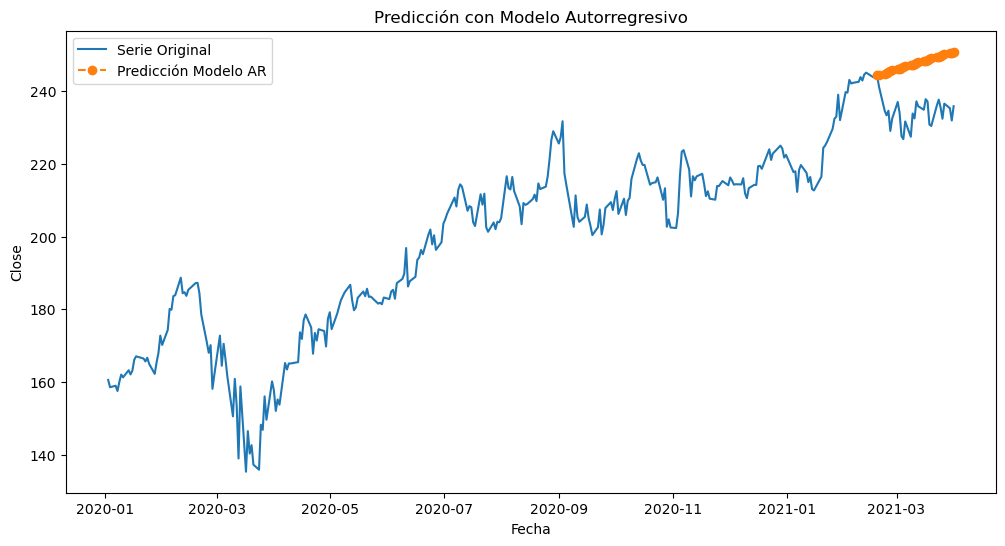

In [243]:
# Mostrar en gráfica la serie original y los valores predichos
plt.figure(figsize=(12, 6))
plt.plot(serie['Date'], serie_static, label='Serie Original')
# Para la gráfica de validación usamos las fechas de los últimos 30 registros
fechas_pred = serie['Date'].iloc[-30:]
plt.plot(fechas_pred, pred_invertida, label='Predicción Modelo AR', marker='o', linestyle='--')
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicción con Modelo Autorregresivo")
plt.legend()
plt.show()

### Pregunta 6 ###
A la vista de los resultados obtenidos en el entrenamiento del modelo, ¿qué podemos decir de los residuos y por tanto de la validez estadística del modelo?. En cuanto a la pinta que tiene el resultado final visualizado en el gráfico, ¿Qué conclusiones podemos sacar sobre el modelo? ¿es adecuado para predecir valores futuros de la serie? ¿De qué manera influye en esta valoración el hecho de que hayamos seleccionado para validar los últimos 30 puntos con respecto a la pinta que tendría si solo hubieran sido los últimos 20?

***Respuesta:***

Segun los residuos y la validez del modelo no parece ser posible predecirlo. Esto es porque los ultimos 30 valores incluyen un declive inesperado si se hubieran seleccionado los últimos 20 podria ser un mejor modelo. Pero siendo un modelo en base a los stocks es mas dificil de predecir ya que estos son afectos por demasiadas variables que no se pueden agregar, como opinion publica, lanzamiento de productos de en la competencia o inseguridad en el mercado en general que afectara a microsoft

Por último, el alumno debe optimizar el modelo, cambiando el orden de las componentes AR, I y MA del modelo ARIMA, hasta llegar a una combinación que mejore el anterior modelo y que pueda ser incluso utilizable para predecir valores futuros de la serie. Para ello puede optar por realizarlo de forma manual probando distintas combinaciones o mediante algún algoritmo automático que encuentre la mejor combinación de ordenes para el modelo.

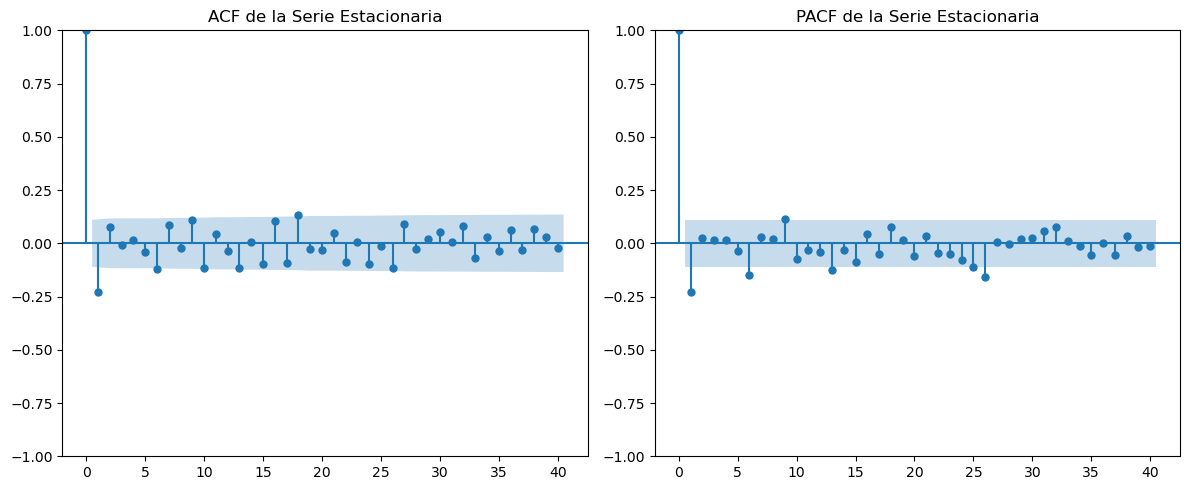

In [246]:
# Para el método manual, evaluar la ACF y PACF de la serie estacionaria (transformada si fuera necesario)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(serie_diff, lags=40, ax=plt.gca())
plt.title('ACF de la Serie Estacionaria')

plt.subplot(1, 2, 2)
plot_pacf(serie_diff, lags=40, ax=plt.gca(), method='ywm')
plt.title('PACF de la Serie Estacionaria')
plt.tight_layout()
plt.show()

In [274]:
# Encontrar los ordenes p y q adecuados para las partes AR y MA
p_opt = 3  
d_opt = 1 
q_opt = 2

In [276]:
# Aplicar el modelo ARIMA incluyendo los ordenes p y q, pero además incluyendo el orden de diferenciación d
train_boxcox = serie_boxcox[:-30]
test_boxcox = serie_boxcox[-30:]


modelo_arima = ARIMA(train_boxcox, order=(p_opt, d_opt, q_opt))
modelo_arima_fit = modelo_arima.fit()
print(modelo_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  284
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -2973.277
Date:                Thu, 27 Feb 2025   AIC                           5958.555
Time:                        13:10:48   BIC                           5980.427
Sample:                             0   HQIC                          5967.325
                                - 284                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0179      0.039     26.259      0.000       0.942       1.094
ar.L2         -0.7145      0.054    -13.160      0.000      -0.821      -0.608
ar.L3         -0.1701      0.040     -4.299      0.0

C:\Users\swart\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


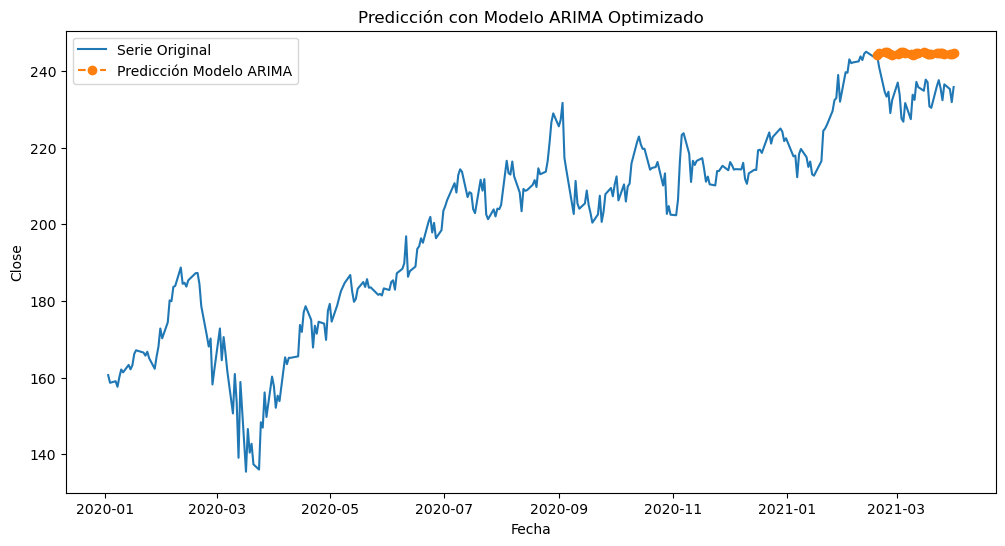

In [278]:
# Predecir y pintar los resultados como en puntos anteriores
forecast_boxcox = modelo_arima_fit.forecast(steps=30)

if lambda_bc != 0:
    forecast_invertido = np.power(forecast_boxcox * lambda_bc + 1, 1 / lambda_bc)
else:
    forecast_invertido = np.exp(forecast_boxcox)

plt.figure(figsize=(12, 6))
plt.plot(serie['Date'], serie_static, label='Serie Original')
fechas_forecast = serie['Date'].iloc[-30:]
plt.plot(fechas_forecast, forecast_invertido, label='Predicción Modelo ARIMA', marker='o', linestyle='--')
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicción con Modelo ARIMA Optimizado")
plt.legend()
plt.show()

### Pregunta 7 ###
Hacer una interpretación libre del modelo entrenado y de los resultados obtenidos. ¿Sería utilizable para predicción de valores futuros de la serie temporal?

***Respuesta:***

En esta ocasion los datos parecen perder su tendencia y conservar una estacionalidad. No es utilizable para predecir valores futuros ya que la estacionalidad es muy reducida y la baja en los valores es demasiado grande para la prediccion